<a href="https://colab.research.google.com/github/Kenshinhuang/Time-series/blob/master/CO2%20Emissions%20in%20the%20U.S..ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load the data
url="https://bd29ee0e-54ab-4daa-9671-d153865d1620.usrfiles.com/ugd/bd29ee_997120a21a134b84b238e63c2c1d39bb.csv"
df=pd.read_csv(url)
df.head()

,label,CO2 Emissions
0,2016,15.502204
1,2015,15.989866
2,2014,16.416576
3,2013,16.362224
4,2012,16.193429


In [2]:
# Rename the "label" column as "Year"
df=df.rename(columns={"label":"Year"})
df=df.iloc[::-1].reset_index(drop=True)
df.head()

,Year,CO2 Emissions
0,1960,15.999779
1,1961,15.681256
2,1962,16.013937
3,1963,16.482762
4,1964,16.968119


In [18]:
import plotly.express as px
fig = px.bar(df, x='Year', y='CO2 Emissions',title="CO2 Emissions in the U.S. in Metric Tons, 1960-2016")
fig.show()

In [4]:
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [5]:
# build an ARIMA model for the time series. 
X = df[["CO2 Emissions"]].values
size = int(len(X) * 0.7) # Use 70% of the data for training.

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# Train, test the model and print out the MAPE.
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=-1)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
mape = np.mean(np.abs(predictions -test )/np.abs(test))
print('MAPE: '+str(mape))

MAPE: 0.023365099550534004


###### The MAPE is less than 10%. In fact, it is a lot smaller than 10%. So, the ARIMA model is decent.

`



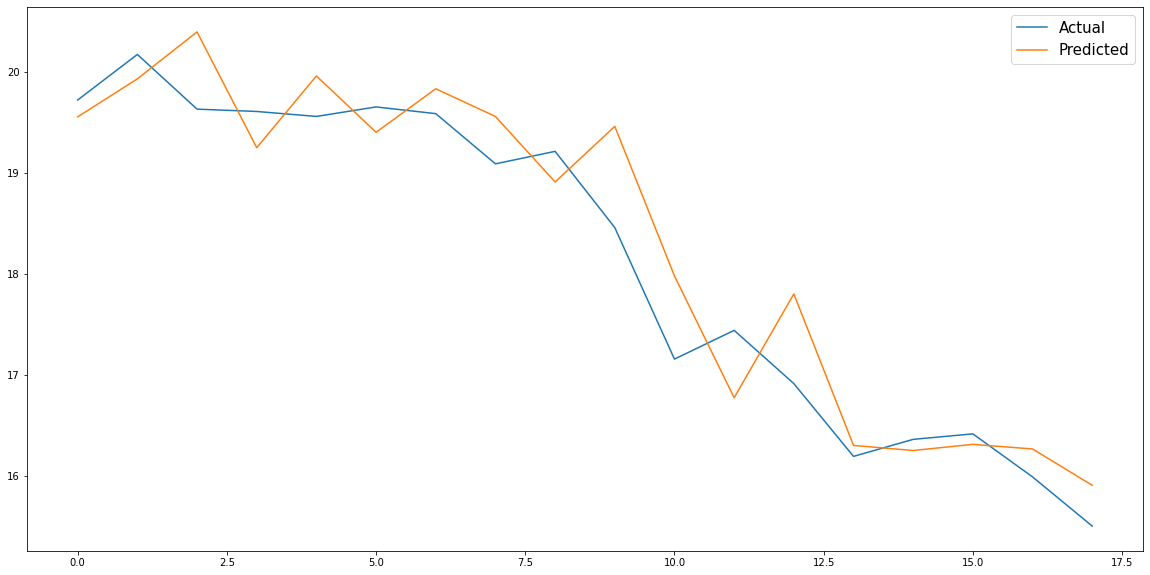

In [7]:
# Plot the actual observations in the test data and their predictions by the model. 
plt.figure(figsize=(20,10))
plt.plot(test,label="Actual")
plt.plot(predictions,label="Predicted")
plt.legend(fontsize=15)
plt.show()

###### As shown, the predictions are one period ahead of the actual observations and are not very useful for predictions. Shift the predictions backward  by one period.

In [8]:
predictions=pd.DataFrame(predictions).shift(-1).dropna().rename(columns={0:"Predicted CO2 Emissions"})
predictions

,Predicted CO2 Emissions
0,19.936810
1,20.402232
2,19.254159
3,19.965316
4,19.406870
5,19.838446
6,19.563807
7,18.914088
8,19.465659
9,17.982210


In [9]:
test=pd.DataFrame(test).rename(columns={0:"CO2 Emissions"})
test

,CO2 Emissions
0,19.727170
1,20.178751
2,19.636505
3,19.613404
4,19.564105
5,19.658371
6,19.591885
7,19.094067
8,19.217898
9,18.461764


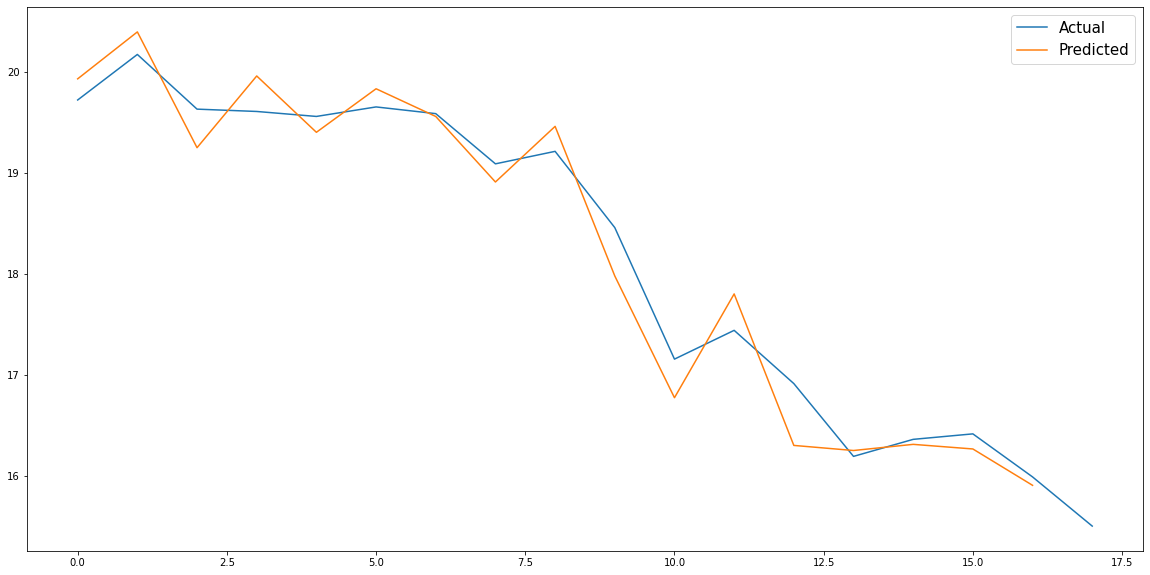

In [10]:
# Plot the actual observations and predictions again.
plt.figure(figsize=(20,10))
plt.plot(test["CO2 Emissions"],label="Actual")
plt.plot(predictions["Predicted CO2 Emissions"],label="Predicted")
plt.legend(fontsize=15)
plt.show()

##### Much better this time. Next, put the year, actual CO2 Emissions and Predictions into one dataframe and calculate the absolute error for each year in the test data.

In [11]:
year=df[["Year"]]
train_year, test_year = year[0:size], year[size:len(X)]
test_year=test_year.reset_index(drop=True)
test_year

,Year
0,1999
1,2000
2,2001
3,2002
4,2003
5,2004
6,2005
7,2006
8,2007
9,2008


In [12]:
test=pd.concat([test_year,test,predictions],axis=1)
test["Absolute Errors"]=np.abs(test["CO2 Emissions"]-predictions["Predicted CO2 Emissions"])
test=test.dropna()
test

,Year,CO2 Emissions,Predicted CO2 Emissions,Absolute Errors
0,1999,19.727170,19.936810,0.209640
1,2000,20.178751,20.402232,0.223482
2,2001,19.636505,19.254159,0.382346
3,2002,19.613404,19.965316,0.351912
4,2003,19.564105,19.406870,0.157235
5,2004,19.658371,19.838446,0.180075
6,2005,19.591885,19.563807,0.028079
7,2006,19.094067,18.914088,0.179978
8,2007,19.217898,19.465659,0.247761
9,2008,18.461764,17.982210,0.479553


##### Use the model to forecast. This is different from predicting. When we predict, we have actual observations, the test data, to compare our predictions to. When we forecast, we want to know what has not happened yet. So, there is no actual observations to compare the forecast values to. We want to see whether the U.S. would be able to achieve net-zero emission by mid-century. So, we are going to forecast from the last year in the table above till 2050. We also want to use the 99% confidence interval. So, set alpha to be 0.01.

In [15]:
fc, se, conf=model_fit.forecast(2050-test["Year"].max(),alpha=0.01)

In [16]:
fc

array([15.90652026, 15.93142513, 15.82090337, 15.80486746, 15.81977749,
       15.78014792, 15.76858364, 15.77204764, 15.75682316, 15.74929494,
       15.74766357, 15.73950629, 15.73335386, 15.72954238, 15.72353316,
       15.71798676, 15.71333279, 15.70795055, 15.70265008, 15.69768318,
       15.69248054, 15.68727972, 15.68220089, 15.67704748, 15.67188589,
       15.66676811, 15.66162736, 15.65648089, 15.65134988, 15.64621203,
       15.64107127, 15.63593587, 15.63079852, 15.62565987, 15.62052305])

###### It seems like the U.S. is not going to achieve net zero emission by 2050. Let's output the confidence intervals for the forecast values.

In [17]:
conf

array([[14.62119395, 17.19184656],
       [13.62883442, 18.23401584],
       [12.88720164, 18.75460509],
       [12.23884695, 19.37088797],
       [11.65351847, 19.98603652],
       [11.11159415, 20.4487017 ],
       [10.61654777, 20.92061951],
       [10.15795259, 21.38614269],
       [ 9.72340903, 21.79023729],
       [ 9.31799756, 22.18059233],
       [ 8.93629498, 22.55903216],
       [ 8.57062607, 22.90838651],
       [ 8.22267565, 23.24403207],
       [ 7.89029139, 23.56879337],
       [ 7.56970935, 23.87735698],
       [ 7.26104396, 24.17492956],
       [ 6.96324983, 24.46341575],
       [ 6.67447294, 24.74142817],
       [ 6.39436852, 25.01093164],
       [ 6.12231671, 25.27304966],
       [ 5.85735122, 25.52760987],
       [ 5.59907582, 25.77548362],
       [ 5.34706485, 26.01733694],
       [ 5.10076408, 26.25333089],
       [ 4.85983644, 26.48393534],
       [ 4.62396815, 26.70956806],
       [ 4.39280694, 26.93044778],
       [ 4.16608749, 27.14687429],
       [ 3.94357063,

##### The further into the future we forecast, the more uncertainity there is. Hence, the further into the future, the wider the confidence intervals become. The forecast shows that even if the U.S. manages to lower its CO2 emissions to the lower bound of the confidence intervals, it will still not achieve net-zero emission by 2050.

##### Is net zero emission ever possible? Let's forecast further into the future, say, 2065.

In [19]:
fc, se, conf=model_fit.forecast(2065-test["Year"].max(),alpha=0.01)

In [20]:
conf

array([[14.62119395, 17.19184656],
       [13.62883442, 18.23401584],
       [12.88720164, 18.75460509],
       [12.23884695, 19.37088797],
       [11.65351847, 19.98603652],
       [11.11159415, 20.4487017 ],
       [10.61654777, 20.92061951],
       [10.15795259, 21.38614269],
       [ 9.72340903, 21.79023729],
       [ 9.31799756, 22.18059233],
       [ 8.93629498, 22.55903216],
       [ 8.57062607, 22.90838651],
       [ 8.22267565, 23.24403207],
       [ 7.89029139, 23.56879337],
       [ 7.56970935, 23.87735698],
       [ 7.26104396, 24.17492956],
       [ 6.96324983, 24.46341575],
       [ 6.67447294, 24.74142817],
       [ 6.39436852, 25.01093164],
       [ 6.12231671, 25.27304966],
       [ 5.85735122, 25.52760987],
       [ 5.59907582, 25.77548362],
       [ 5.34706485, 26.01733694],
       [ 5.10076408, 26.25333089],
       [ 4.85983644, 26.48393534],
       [ 4.62396815, 26.70956806],
       [ 4.39280694, 26.93044778],
       [ 4.16608749, 27.14687429],
       [ 3.94357063,

##### It seems that if the U.S. can lower its annual CO2 emissions to the lower bound, then it might actually have a chance to achieve net-zero emission by 2065. At the same time, if nothing is done to curb CO2 emission, by 2065, instead of net-zero, CO2 emission might be double of its current amount.